## Gerando Nuvem de Pontos

In [32]:
import pdal ## para leitura e processamento de nuvem de pontos
import json 
import numpy as np 

In [33]:
import geopandas as gpd ## adaptação do Pandas para GIS
import pandas as pd

In [34]:
areas = gpd.read_file("./gis/area-de-analise-BN8AU-2.geojson")

In [35]:
areas['area'] = areas.area

In [36]:
areas

,Name,description,timestamp,begin,end,geometry,area
0,Terreno - Projeto,None,None,None,None,"POLYGON Z ((333264.881 7391451.155 0.000, 3333...",1.981811e+04
1,Área de Intervenção - Projeto e PUPSP,None,None,None,None,"POLYGON Z ((333140.172 7391206.126 0.000, 3332...",1.309563e+05
2,Área de Intervenção - PUPSP,None,None,None,None,"POLYGON Z ((333347.106 7391333.800 0.000, 3328...",5.738222e+05
3,Área de Análise - PUPSP,None,None,None,None,"POLYGON Z ((332759.204 7391145.524 0.000, 3329...",1.869758e+06


In [38]:
AREA = 0
s = areas.iloc[AREA].geometry
bounds = ([s.bounds[0], s.bounds[2]], [s.bounds[1], s.bounds[3]])

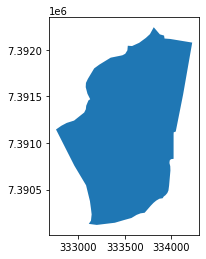

In [42]:
areas.plot()

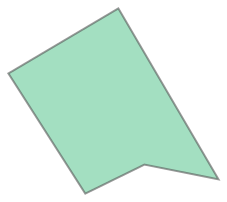

In [43]:
display(s)

In [39]:
ept = [
    {
      "type": "readers.ept",
      "filename": "https://ept-m3dc-pmsp.s3-sa-east-1.amazonaws.com/ept.json",
      "bounds": str(bounds),
      # Resolução de 1 metro apenas para a Área de Análise
      "resolution": 10,
      "threads":6
    },
#     {
#         "type":"filters.voxelcentroidnearestneighbor",
#         "cell":0.5
#     },
    {
        "type":"filters.crop",
        "polygon":s.wkt
    },
#     {   
#         "type":"filters.hag_delaunay"
#     },
    {
        "type":"writers.las",
        "compression":"laszip",
        "filename":f"resultados/{areas.iloc[AREA].Name}.laz"
    }
]

pipeline = pdal.Pipeline(json.dumps(ept))
pipeline.validate()
%time n_points = pipeline.execute()
print(f'Pipeline selected {n_points} points')

CPU times: user 4.47 s, sys: 154 ms, total: 4.62 s
Wall time: 3.84 s
Pipeline selected 313816 points


## Vamos ver como isso fica lá no CloudCompare?

* Carregando o arquivo `resultados/Área de Intervenção - Projeto e PUPSP.laz`

## Gerando raster a partir do LiDAR 3D

In [ ]:
cropper = [
    {
      "type": "readers.las",
      "filename": "resultados/Área de Análise - PUPSP.laz",
#       "bounds": str(bounds),
#       "threads":6
    },
    {
      "type":"filters.assign",
      "assignment":"Classification[:]=0"
    },
#     {
#       "type":"filters.elm"
#     },
#     {
#       "type":"filters.outlier"
#     },
#     {
#         "type": "filters.ferry",
#         "dimensions": "=>ReturnNumber, =>NumberOfReturns" 
#     },
#     {
#         "type": "filters.assign",
#         "assignment": "NumberOfReturns[:]=1"
#     },
#     {
#         "type": "filters.assign",
#         "assignment": "ReturnNumber[:]=1"
#     },
    {
      "type":"filters.smrf",
      "cell": 1,
#       "last":'true',
      "ignore":"Classification[7:7]",
      "slope":0.2,
      "window":16,
      "threshold":0.45,
      "scalar":1.2
    },
    {
      "type":"filters.range",
      "limits":"Classification[2:2]"
    },
#     {
#       "filename":f"resultados/MDT-{areas.iloc[AREA].Name}-1m.tif",
#       "gdaldriver":"GTiff",
#       "output_type":"all",
#       "resolution":"1.0",
#       "type": "writers.gdal"
#     },
    {
      "filename":f"resultados/MDT-{areas.iloc[AREA].Name}-5m.tif",
      "gdaldriver":"GTiff",
      "output_type":"all",
      "resolution":"5.0",
      "output_type": "mean",
      "type": "writers.gdal"
    },
    {
      "filename":f"resultados/MDT-{areas.iloc[AREA].Name}-10m.tif",
      "gdaldriver":"GTiff",
      "output_type":"all",
      "resolution":"10.0",
      "output_type": "mean",
      "type": "writers.gdal"
    }
]

pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print(f'Pipeline selected {n_points} points')

In [44]:
## Dividindo o arquivo para arquivos menores e poderem ser disponibilizados pelo GitHub
!pdal split --capacity 5000000 "resultados/Área de Análise - PUPSP.laz" "resultados/Área de Análise - PUPSP.laz"

PDAL: Unable to open stream for 'resultados/Área de Análise - PUPSP.laz' with error 'No such file or directory'



In [8]:
!rm "resultados/Área de Análise - PUPSP.laz"

## Preparando o Raster DEM

In [7]:
import rasterio
from rasterio.plot import show
from rasterio import fill, mask

In [8]:
dataset = rasterio.open('./resultados/MDT-Área de Análise - PUPSP-5m.tif')
dataset.read(1,)
dataset_filled = fill.fillnodata(dataset.read(1), mask=dataset.read_masks(1), max_search_distance=5)

In [9]:
dataset_filled[dataset_filled == -9999.] = np.nan

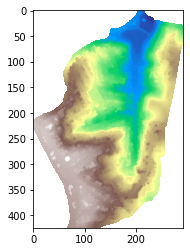

In [10]:
show(dataset_filled, cmap='terrain')

In [11]:
# dataset_filled.tofile('./resultados/MDT-Área de Análise - PUPSP-5m - filled.tif')

with rasterio.open(
    './resultados/MDT-Área de Análise - PUPSP-5m - filled.tif',
    'w',
    driver = 'GTiff',
    height = dataset_filled.shape[0],
    width = dataset_filled.shape[1],
    count = 1,
    dtype = dataset_filled.dtype,
    crs = 'epsg:31983',
    transform = dataset.transform
) as dst:
    dst.write(dataset_filled, 1)

## Vamos ver como fica isso lá no QGis?

* Importando `/resultados/MDT-Área de Análise - PUPSP-5m - filled.tif`

## Analisando drenagem

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid ## Bilbioteca para trabalhar com hidrografia em Python
# import mplleaflet
%matplotlib inline

In [13]:
grid = Grid.from_raster('./resultados/MDT-Área de Análise - PUPSP-5m - filled.tif', data_name='dem')

In [14]:
# grid.dem[grid.dem == -9999.] = np.nan

In [45]:
def plotFigure(data, label, cmap='terrain'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

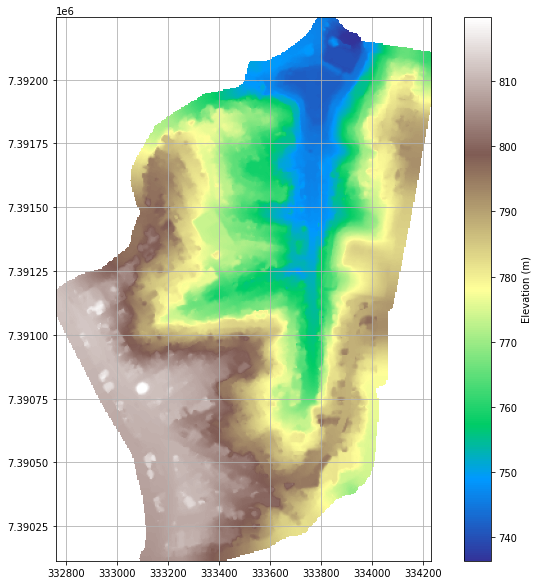

In [46]:
plotFigure(grid.view('dem', nodata=np.nan), 'Elevation (m)')

In [47]:
# Detect depressions
depressions = grid.detect_depressions('dem')
grid.fill_depressions(data='dem', out_name='flooded_dem')

In [48]:
# grid.nodata = np.nan
# grid.mask = ~np.isnan(grid.dem)

In [49]:
# Detect flats
flats = grid.detect_flats('flooded_dem', nodata=np.nan)

In [52]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
# plotFigure(grid.view('inflated_dem', nodata=np.nan), 'Elevation (m)')

In [53]:
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow direction based on corrected DEM
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

In [22]:
# grid.mask = ~np.isnan(grid.dem)

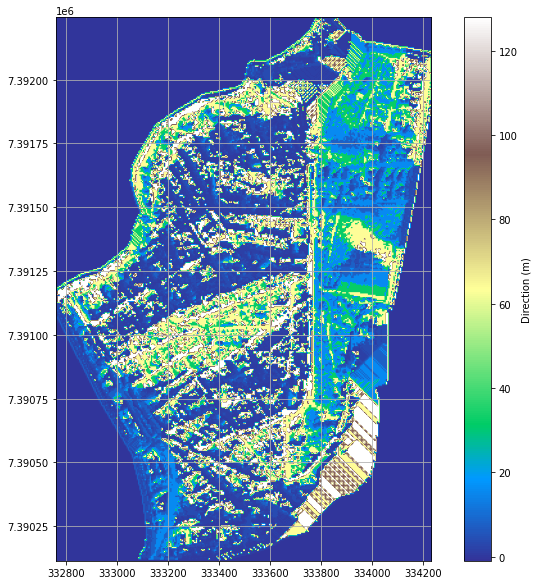

In [54]:
plotFigure(grid.view('dir', nodata=np.nan, apply_mask=True), 'Direction (m)')

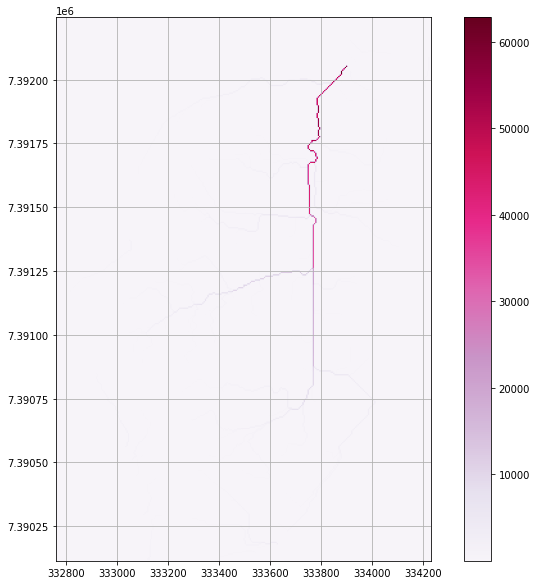

In [55]:
plotFigure(grid.view('acc', nodata=np.nan, apply_mask=True), '', cmap='PuRd')

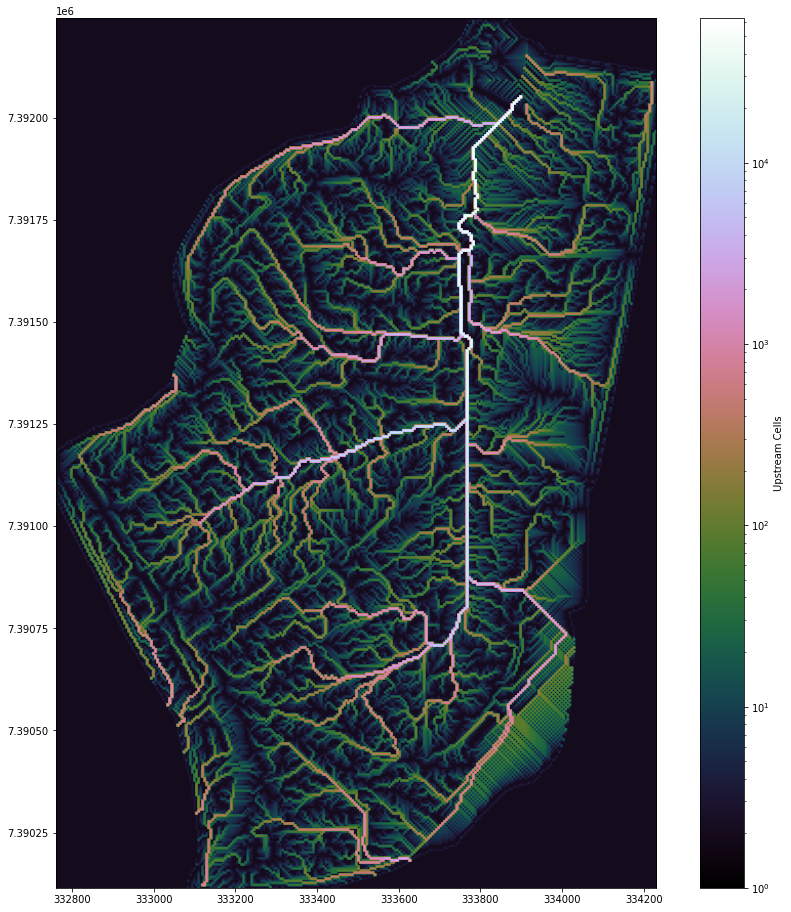

In [57]:
fig, ax = plt.subplots(figsize=(16,16))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')

## Extraindo drenagem em vetor

In [26]:
branches = grid.extract_river_network('dir', 'acc', threshold=250)

In [27]:
len(branches['features'])

185

In [28]:
branches.type = "FeatureCollection"

In [29]:
branches.name = "cusros_dagua-SIRGAS2000"

In [30]:
branches.crs = { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::31983" } }

In [31]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

saveDict(branches, './resultados/cusros_dagua.geojson')

## Vamos ver no QGis, como essa rede de drenagem ficou?

* importando o arquivo `resultados/cusros_dagua.geojson`

## TRabalhando com dados do IPTU

In [58]:
df = pd.read_csv("./gis/IPTU_2020.zip", compression='zip', error_bad_lines=False, encoding='iso-8859-9', sep=';')
df.head()

,NUMERO DO CONTRIBUINTE,ANO DO EXERCICIO,NUMERO DA NL,DATA DO CADASTRAMENTO,TIPO DE CONTRIBUINTE 1,CPF/CNPJ DO CONTRIBUINTE 1,NOME DO CONTRIBUINTE 1,TIPO DE CONTRIBUINTE 2,CPF/CNPJ DO CONTRIBUINTE 2,NOME DO CONTRIBUINTE 2,...,ANO DA CONSTRUCAO CORRIGIDO,QUANTIDADE DE PAVIMENTOS,TESTADA PARA CALCULO,TIPO DE USO DO IMOVEL,TIPO DE PADRAO DA CONSTRUCAO,TIPO DE TERRENO,FATOR DE OBSOLESCENCIA,ANO DE INICIO DA VIDA DO CONTRIBUINTE,MES DE INICIO DA VIDA DO CONTRIBUINTE,FASE DO CONTRIBUINTE
0,0010030001-4,2020,1,11/01/20,PESSOA FISICA (CPF),XXXXXX0214XXXX,MARCIO MOURCHED,NaN,,NaN,...,1924,1,"13,00",Loja,Comercial horizontal - padrão B,De esquina,"0,20",1963,1,0
1,0010030002-2,2020,1,11/01/20,PESSOA FISICA (CPF),XXXXXX0214XXXX,MARCIO MOURCHED,NaN,,NaN,...,1944,1,"6,00",Loja,Comercial horizontal - padrão B,Normal,"0,20",1963,1,0
2,0010030003-0,2020,1,11/01/20,PESSOA FISICA (CPF),XXXXXX0214XXXX,MARCIO MOURCHED,NaN,,NaN,...,1965,2,"7,85",Loja,Comercial horizontal - padrão B,Normal,"0,30",1963,1,0
3,0010030004-9,2020,1,11/01/20,PESSOA FISICA (CPF),XXXXXX2094XXXX,AUGUSTO CESAR DE MATTOS JUNIOR,NaN,,NaN,...,1944,1,"6,05",Loja,Comercial horizontal - padrão B,Normal,"0,20",1963,1,0
4,0010030005-7,2020,1,11/01/20,PESSOA FISICA (CPF),XXXXXX2094XXXX,AUGUSTO CESAR DE MATTOS JUNIOR,NaN,,NaN,...,1944,1,"6,70",Loja,Comercial horizontal - padrão B,Normal,"0,20",1963,1,0


In [104]:
df['VALOR DO M2 DO TERRENO'] = df['VALOR DO M2 DO TERRENO'].str.replace(',','.').astype('float')
df['VALOR DO M2 DE CONSTRUCAO'] = df['VALOR DO M2 DE CONSTRUCAO'].str.replace(',','.').astype('float')
df['TESTADA PARA CALCULO'] = df['TESTADA PARA CALCULO'].str.replace(',','.').astype('float')
df['FATOR DE OBSOLESCENCIA'] = df['FATOR DE OBSOLESCENCIA'].str.replace(',','.').astype('float')


In [72]:
gdf_lotes = gpd.read_file('./resultados/Lotes da área de análise.gpkg')
len(gdf_lotes)

3773

In [60]:
gdf_lotes_individuais = gdf_lotes[gdf_lotes.lo_lote != '0000']

In [61]:
gdf_condominios = gdf_lotes[gdf_lotes.lo_lote == '0000']

In [62]:
sqls_individuais = gdf_lotes_individuais.lo_setor + gdf_lotes_individuais.lo_quadra + gdf_lotes_individuais.lo_lote

In [63]:
sqls_individuais

0       0380630055
1       0380630024
3       0380630029
4       0380630018
5       0380630016
           ...    
3767    0380800043
3768    0380790045
3769    0390180015
3770    0380810014
3771    0390070008
Length: 3481, dtype: object

In [64]:
sqs_condominiais = gdf_condominios.lo_setor + gdf_condominios.lo_quadra + gdf_condominios.lo_condomi

In [65]:
sqs_condominiais

2       03806303
20      03805918
21      03806002
34      03805911
38      03807901
          ...   
3733    03901801
3734    03903103
3737    03908001
3765    03907203
3772    03806105
Length: 292, dtype: object

In [68]:
df_lotes_individuais = df[df['NUMERO DO CONTRIBUINTE'].str[:10].isin(sqls_individuais)]

In [69]:
df_condominios = df[(df['NUMERO DO CONTRIBUINTE'].str[:6] + df['NUMERO DO CONDOMINIO'].str[:2]).isin(sqs_condominiais)]

In [70]:
iptus_area_analise = pd.concat([df_lotes_individuais, df_condominios])

In [71]:
len(df_lotes_individuais) + len(df_condominios)

14586

### Gravando o arquivo de IPTUs da área de análise

In [114]:
iptus_area_analise.to_csv('./resultados/IPTUs 2020 - Área de análise.csv')

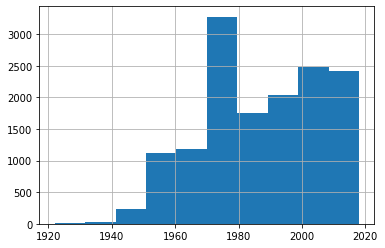

In [115]:
iptus_area_analise[iptus_area_analise['ANO DA CONSTRUCAO CORRIGIDO'] > 1750]['ANO DA CONSTRUCAO CORRIGIDO'].hist()

In [116]:
iptus_area_analise.columns

Index(['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO', 'NUMERO DA NL',
       'DATA DO CADASTRAMENTO', 'TIPO DE CONTRIBUINTE 1',
       'CPF/CNPJ DO CONTRIBUINTE 1', 'NOME DO CONTRIBUINTE 1',
       'TIPO DE CONTRIBUINTE 2', 'CPF/CNPJ DO CONTRIBUINTE 2',
       'NOME DO CONTRIBUINTE 2', 'NUMERO DO CONDOMINIO', 'CODLOG DO IMOVEL',
       'NOME DE LOGRADOURO DO IMOVEL', 'NUMERO DO IMOVEL',
       'COMPLEMENTO DO IMOVEL', 'BAIRRO DO IMOVEL', 'REFERENCIA DO IMOVEL',
       'CEP DO IMOVEL', 'QUANTIDADE DE ESQUINAS/FRENTES', 'FRACAO IDEAL',
       'AREA DO TERRENO', 'AREA CONSTRUIDA', 'AREA OCUPADA',
       'VALOR DO M2 DO TERRENO', 'VALOR DO M2 DE CONSTRUCAO',
       'ANO DA CONSTRUCAO CORRIGIDO', 'QUANTIDADE DE PAVIMENTOS',
       'TESTADA PARA CALCULO', 'TIPO DE USO DO IMOVEL',
       'TIPO DE PADRAO DA CONSTRUCAO', 'TIPO DE TERRENO',
       'FATOR DE OBSOLESCENCIA', 'ANO DE INICIO DA VIDA DO CONTRIBUINTE',
       'MES DE INICIO DA VIDA DO CONTRIBUINTE', 'FASE DO CONTRIBUINTE'],
      dtype

In [117]:
iptus_area_analise['TIPO DE PADRAO DA CONSTRUCAO'].unique()

array(['Residencial horizontal - padrão C',
       'Comercial vertical - padrão B', 'Comercial horizontal - padrão C',
       'Comercial horizontal - padrão B',
       'Templo/Clube/Ginásio ou Estádio es',
       'Residencial horizontal - padrão D',
       'Residencial horizontal - padrão E', 'TERRENO',
       'Comercial vertical - padrão D',
       'Barracão/Telheiro/Oficina/Posto de',
       'Residencial horizontal - padrão B',
       'Comercial vertical - padrão C', 'Residencial vertical - padrão D',
       'Residencial vertical - padrão C',
       'Oficina/Posto de serviço/Armazém/D',
       'Residencial horizontal - padrão F',
       'Comercial horizontal - padrão D',
       'Residencial horizontal - padrão A',
       'Comercial horizontal - padrão A',
       'Residencial vertical - padrão B',
       'Barracão/Telheiro/Oficina - padrão',
       'Edifício de garagens - padrão A',
       'Residencial vertical - padrão E',
       'Residencial vertical - padrão F', 'Comercial vertical

In [118]:
iptus_area_analise['TIPO DE USO DO IMOVEL'].unique()

array(['Residência', 'Loja e residência (predominância comercial)',
       'Loja',
       'Outras edificações de uso especial, com utilização múltipla',
       'Asilo, orfanato, creche, seminário ou convento', 'Templo',
       'Residência e outro uso (predominância residencial)',
       'Residência coletiva, exclusive cortiço (mais de uma residência no lote)',
       'Prédio de escritório ou consultório, não em condomínio, com ou sem lojas',
       'Outras edificações de uso comercial, com utilização múltipla',
       'Outras edificações de uso coletivo, com utilização múltipla',
       'Terreno', 'Escola',
       'Outras edificações de uso de serviço, com utilização múltipla',
       'Garagem (exclusive em prédio em condomínio)', 'Oficina',
       'Prédio de apartamento, não em condomínio, de uso exclusivamente residencial',
       'Cinema, teatro, casa de diversão, clube ou congênere',
       'Posto de serviço',
       'Prédio de apartamento, não em condomínio, de uso misto (apartame

## Mas e a dimensão espacial?

* Vamos agregar essas informações do IPTU na Geometria do Lote Fiscal
* Ahhhh como eu queria pode ter feito isso há um ano atrás ...

In [119]:
df_lotes_individuais['sqlc'] = df_lotes_individuais['NUMERO DO CONTRIBUINTE'].str[:10] + df['NUMERO DO CONDOMINIO'].str[:2]
df_condominios['sqlc'] = df['NUMERO DO CONTRIBUINTE'].str[:6] + '0000' + df['NUMERO DO CONDOMINIO'].str[:2]

/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [120]:
df_condominios_sqlc = df_condominios.groupby(['sqlc']).agg({
    'NUMERO DO CONTRIBUINTE': 'count',
    'AREA CONSTRUIDA': 'mean',
    'AREA DO TERRENO': 'max',
    'AREA OCUPADA': 'max',
    'QUANTIDADE DE ESQUINAS/FRENTES': 'max',
    'VALOR DO M2 DO TERRENO': 'max',
    'VALOR DO M2 DE CONSTRUCAO': 'max',
    'ANO DA CONSTRUCAO CORRIGIDO': 'max',
    'TIPO DE USO DO IMOVEL': 'max', #'unique',
    'TIPO DE PADRAO DA CONSTRUCAO': 'max',
    'TIPO DE TERRENO': 'max',
    'TESTADA PARA CALCULO': 'max',
    'QUANTIDADE DE PAVIMENTOS': 'max',
    'FATOR DE OBSOLESCENCIA': 'max'
}).rename(columns = {
    'NUMERO DO CONTRIBUINTE': 'total_unidades',
    'AREA CONSTRUIDA': 'area_construida_media_por_unidade',
    'AREA DO TERRENO': 'area_do_terreno',
    'AREA OCUPADA': 'area_ocupada',
    'QUANTIDADE DE ESQUINAS/FRENTES': 'quantidade_de_frentes',
    'VALOR DO M2 DO TERRENO': 'valor_metro_quadrado_terreno',
    'VALOR DO M2 DE CONSTRUCAO': 'valor_metro_quadrado_construcao',
    'ANO DA CONSTRUCAO CORRIGIDO': 'ano_construcao',
    'TIPO DE USO DO IMOVEL': 'uso_imovel', #'unique',
    'TIPO DE PADRAO DA CONSTRUCAO': 'padrao_imovel',
    'TIPO DE TERRENO': 'tipo_terreno',
    'TESTADA PARA CALCULO': 'testada',
    'QUANTIDADE DE PAVIMENTOS': 'quantidade_de_pavimentos',
    'FATOR DE OBSOLESCENCIA': 'fator_de_obsolecencia'
})

In [121]:
df_lotes_individuais_sqlc = df_lotes_individuais.groupby(['sqlc']).agg({
    'NUMERO DO CONTRIBUINTE': 'count',
    'AREA CONSTRUIDA': 'mean',
    'AREA DO TERRENO': 'max',
    'AREA OCUPADA': 'max',
    'QUANTIDADE DE ESQUINAS/FRENTES': 'max',
    'VALOR DO M2 DO TERRENO': 'max',
    'VALOR DO M2 DE CONSTRUCAO': 'max',
    'ANO DA CONSTRUCAO CORRIGIDO': 'max',
    'TIPO DE USO DO IMOVEL': 'max', #'unique',
    'TIPO DE PADRAO DA CONSTRUCAO': 'max',
    'TIPO DE TERRENO': 'max',
    'TESTADA PARA CALCULO': 'max',
    'QUANTIDADE DE PAVIMENTOS': 'max',
    'FATOR DE OBSOLESCENCIA': 'max'
}).rename(columns = {
    'NUMERO DO CONTRIBUINTE': 'total_unidades',
    'AREA CONSTRUIDA': 'area_construida_media_por_unidade',
    'AREA DO TERRENO': 'area_do_terreno',
    'AREA OCUPADA': 'area_ocupada',
    'QUANTIDADE DE ESQUINAS/FRENTES': 'quantidade_de_frentes',
    'VALOR DO M2 DO TERRENO': 'valor_metro_quadrado_terreno',
    'VALOR DO M2 DE CONSTRUCAO': 'valor_metro_quadrado_construcao',
    'ANO DA CONSTRUCAO CORRIGIDO': 'ano_construcao',
    'TIPO DE USO DO IMOVEL': 'uso_imovel', #'unique',
    'TIPO DE PADRAO DA CONSTRUCAO': 'padrao_imovel',
    'TIPO DE TERRENO': 'tipo_terreno',
    'TESTADA PARA CALCULO': 'testada',
    'QUANTIDADE DE PAVIMENTOS': 'quantidade_de_pavimentos',
    'FATOR DE OBSOLESCENCIA': 'fator_de_obsolecencia'
})

In [122]:
lotes = pd.concat([df_condominios_sqlc, df_lotes_individuais_sqlc])

In [123]:
lotes

,total_unidades,area_construida_media_por_unidade,area_do_terreno,area_ocupada,quantidade_de_frentes,valor_metro_quadrado_terreno,valor_metro_quadrado_construcao,ano_construcao,uso_imovel,padrao_imovel,tipo_terreno,testada,quantidade_de_pavimentos,fator_de_obsolecencia
sqlc,,,,,,,,,,,,,,
034046000001,6,71.000000,325,140,0,2847.0,2213.0,1956,Apartamento em condomínio,Residencial vertical - padrão C,Normal,21.00,3,0.20
034046000002,30,79.433333,1044,360,0,2854.0,2213.0,1970,Garagem (unidade autônoma) em edifício em cond...,Residencial vertical - padrão C,Normal,12.00,8,0.39
034046000003,6,73.833333,376,270,0,2847.0,2213.0,1970,Apartamento em condomínio,Residencial vertical - padrão C,Normal,23.00,3,0.39
034046000004,21,163.619048,800,400,0,2854.0,2213.0,1970,Apartamento em condomínio,Residencial vertical - padrão C,Normal,18.00,12,0.39
034046000005,20,181.750000,530,420,2,2854.0,2584.0,1970,Apartamento em condomínio,Residencial vertical - padrão D,De duas ou mais,37.30,11,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
039134002000,1,164.000000,115,80,0,2506.0,1816.0,1970,Residência,Residencial horizontal - padrão C,Normal,4.41,2,0.39
039134002100,1,141.000000,113,80,0,2506.0,1816.0,1970,Residência,Residencial horizontal - padrão C,Normal,4.41,2,0.39
039134002200,1,187.000000,112,78,1,2506.0,1816.0,1975,Residência,Residencial horizontal - padrão C,De esquina,4.42,3,0.48


## Agora é só salvar tudo e visualizar no Qgis

In [124]:
gdf_lotes['sqlc'] = gdf_lotes.lo_setor + gdf_lotes.lo_quadra + gdf_lotes.lo_lote + gdf_lotes.lo_condomi

In [125]:
gdf_lotes.merge(lotes, on='sqlc').to_file('resultados/lotes_com_informacoes_iptu_2020.gpkg', driver='GPKG')

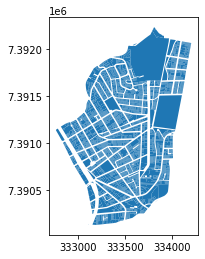

In [73]:
gdf_lotes.plot()